In [1]:
import numpy as np
import mitsuba as mi
import matplotlib as mpl
import matplotlib.pyplot as plt

# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

from sionna.rt import load_scene, Camera, Transmitter, Receiver, PlanarArray,\
                      PathSolver, RadioMapSolver, load_mesh, watt_to_dbm, transform_mesh,\
                      cpx_abs_square

no_preview = True # Toggle to False to use the preview widget
                  # instead of rendering for scene visualization

In [2]:
def config_scene(num_rows, num_cols):
    """Load and configure a scene"""
    scene = load_scene(sionna.rt.scene.etoile)
    scene.bandwidth=100e6

    # Configure antenna arrays for all transmitters and receivers
    scene.tx_array = PlanarArray(num_rows=num_rows,
                                 num_cols=num_cols,
                                 pattern="tr38901",
                                 polarization="V")

    scene.rx_array = PlanarArray(num_rows=1,
                                 num_cols=1,
                                 pattern="iso",
                                 polarization="V")

    # Place transmitters
    positions = np.array(
                 [[-150.3, 21.63, 42.5],
                  [-125.1, 9.58, 42.5],
                  [-104.5, 54.94, 42.5],
                  [-128.6, 66.73, 42.5],
                  [172.1, 103.7, 24],
                  [232.8, -95.5, 17],
                  [80.1, 193.8, 21]
                 ])
    look_ats = np.array(
                [[-216, -21,0],
                 [-90, -80, 0],
                 [-16.5, 75.8, 0],
                 [-164, 153.7, 0],
                 [247, 92, 0],
                 [211, -180, 0],
                 [126.3, 194.7, 0]
                ])
    power_dbms = [23, 23, 23, 23, 23, 23, 23]

    car_materal = sionna.rt.ITURadioMaterial("car-material","metal",thickness = 0.01,color = (0.8, 0.1, 0.1))
    num_cars = 3
    cars = [sionna.rt.SceneObject(fname = sionna.rt.scene.low_poly_car, name = f"car-{i}", radio_material=car_materal) for i in range(num_cars)]
    scene.edit(add=cars)
    c = mi.Point3f(-150.3, 21.63, 0.75)
    cars[0].position  = c + mi.Point3f(2, 2, 0)
    cars[1].position  = c + mi.Point3f(-10, -2, 0)
    cars[2].position  = c + mi.Point3f(3, 3, 0)

    cars[0].orientation = [0, 0, 0]
    cars[1].orientation = [0, 0, 0]
    cars[2].orientation = [0, 0, 0]

    scene.add(Transmitter(name=f'tx0',
                          position=positions[0],
                          look_at=look_ats[0],
                          power_dbm=power_dbms[0]))
    # for i, position in enumerate(positions):
    #     scene.add(Transmitter(name=f'tx{i}',
    #                           position=position,
    #                           look_at=look_ats[i],
    #                           power_dbm=power_dbms[i]))

    return scene

In [ ]:
# num_rows=8
# num_cols=2
num_rows=1
num_cols=1
scene_etoile = config_scene(num_rows, num_cols)
rm_solver = RadioMapSolver()
# Compute the SINR map
rm_etoile = rm_solver(scene_etoile,
                      max_depth=5,
                      samples_per_tx=10**7,
                      cell_size=(1, 1))

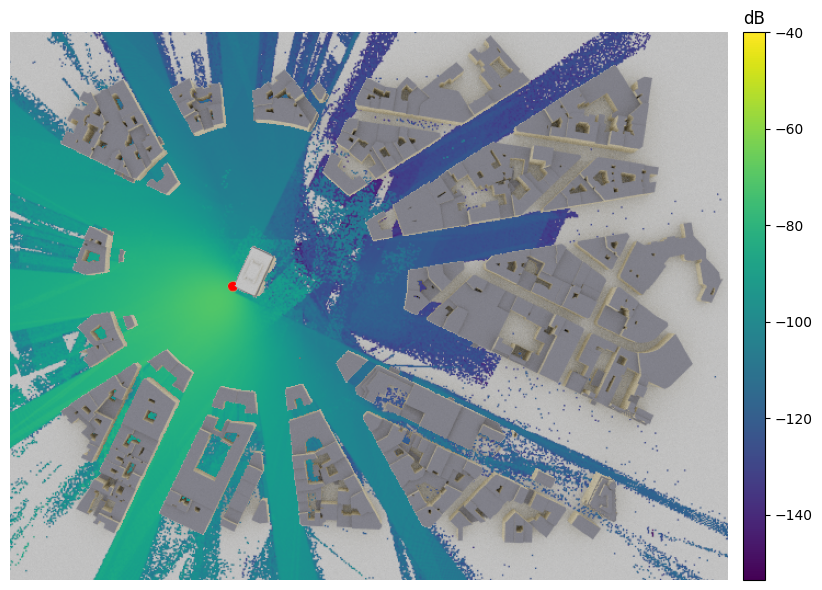

In [8]:
if no_preview:
    # Render an image
    cam = Camera(position=[0,0,1000],
                     orientation=np.array([0,np.pi/2,-np.pi/2]))
    scene_etoile.render(camera=cam,
                        radio_map=rm_etoile,
                        rm_show_color_bar=True,
                        rm_vmax=-40);
else:
    # Show preview
    scene_etoile.preview(radio_map=rm_etoile,
                         rm_metric="rss",
                         rm_show_color_bar=True,
                         rm_vmin=-50)